<a href="https://colab.research.google.com/github/Rin-niee/MPSI/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ЧАСТЬ 1

In [3]:
pip install pandas umap-learn transformers datasets scikit-learn torch evaluate

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import umap
from mpl_toolkits.mplot3d import Axes3D

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

1. Загрузка данных(был взят какой-то готовый датасетик из уже встроенных в библиотеку, 20000 новостей/статей, с фильтрацией по категориям). Датасет на английском языке, т.к данные могут быть точнее(?)

In [6]:
categories = None #здесь нужно выбирать категории конкретные, я решила взять всю совокупность из 20 категорий
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
labels = newsgroups.target
label_names = newsgroups.target_names

Урезанный датасетик для ускорения работы программы

In [7]:
import random
from collections import defaultdict

samples_per_class = 50
class_counts = defaultdict(int)

texts_subset = []
labels_subset = []

combined = list(zip(texts, labels))
random.shuffle(combined)  # перемешаем, чтобы классы шли не группами

for text, label in combined:
    if class_counts[label] < samples_per_class:
        texts_subset.append(text)
        labels_subset.append(label)
        class_counts[label] += 1
    if all(count >= samples_per_class for count in class_counts.values()):
        break

texts = texts_subset
labels = labels_subset

2. Предобработка текста(лемматизируем и убираем все ненужные стоп-слова)

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # убрать пунктуацию
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

Чистенький текст:

In [9]:
clean_texts = [preprocess(text) for text in texts]

3. Анализируем данные(распределение статей по категориям) - тут я вновь взяла старые данные, просто с указанием единички, чтобы было проще

In [10]:
texts1 = newsgroups.data
labels1 = newsgroups.target
label_names1 = newsgroups.target_names

In [11]:
clean_texts1 = [preprocess(text) for text in texts1]

Количество документов: 18846
Количество категорий: 20


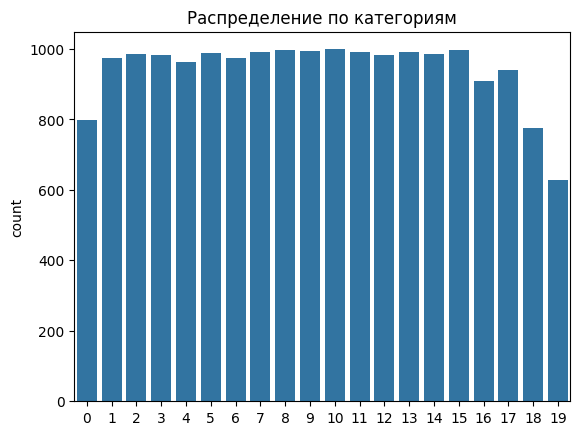

In [12]:
print(f"Количество документов: {len(clean_texts1)}")
print(f"Количество категорий: {len(label_names1)}")
sns.countplot(x=labels1) #категории взяты цифрами, потому что без них совсем уродливо
plt.title("Распределение по категориям")
plt.show()

4. Векторизируем с использованием специальной библиотеки

In [13]:
vectorizer = TfidfVectorizer(max_features=20000) #увеличила количество на всякий случай, чтобы было поточнее
X = vectorizer.fit_transform(clean_texts)
X1 = vectorizer.fit_transform(clean_texts1)

5. Кластеризация

In [14]:
kmeans = KMeans(n_clusters=len(label_names1), random_state=42)
clusters = kmeans.fit_predict(X1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


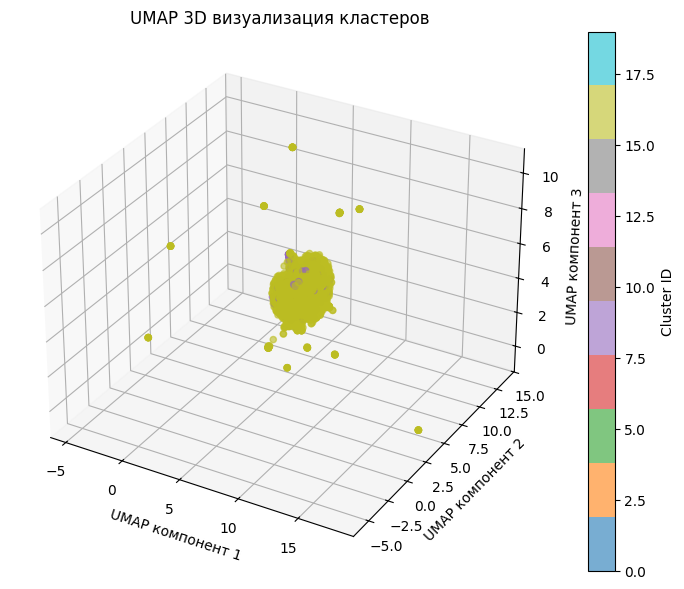

In [15]:
# Применяем UMAP для уменьшения размерности до 3D
umap_model = umap.UMAP(n_components=3, random_state=42)
X_umap_3d = umap_model.fit_transform(X1.toarray())

# Визуализируем результаты кластеризации в 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2],
                     c=clusters, cmap='tab10', alpha=0.6)

ax.set_title("UMAP 3D визуализация кластеров")
ax.set_xlabel("UMAP компонент 1")
ax.set_ylabel("UMAP компонент 2")
ax.set_zlabel("UMAP компонент 3")
plt.colorbar(scatter, ax=ax, label='Cluster ID')
plt.show()

6. Сравнение меток настоящих и после кластеризации

In [16]:
ari = adjusted_rand_score(labels1, clusters)
sil_score = silhouette_score(X1, clusters)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")

Adjusted Rand Index (ARI): 0.0007
Silhouette Score: -0.0163


<ipython-input-19-9e5ce327010d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='coolwarm')
<ipython-input-19-9e5ce327010d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=clusters, palette='viridis')


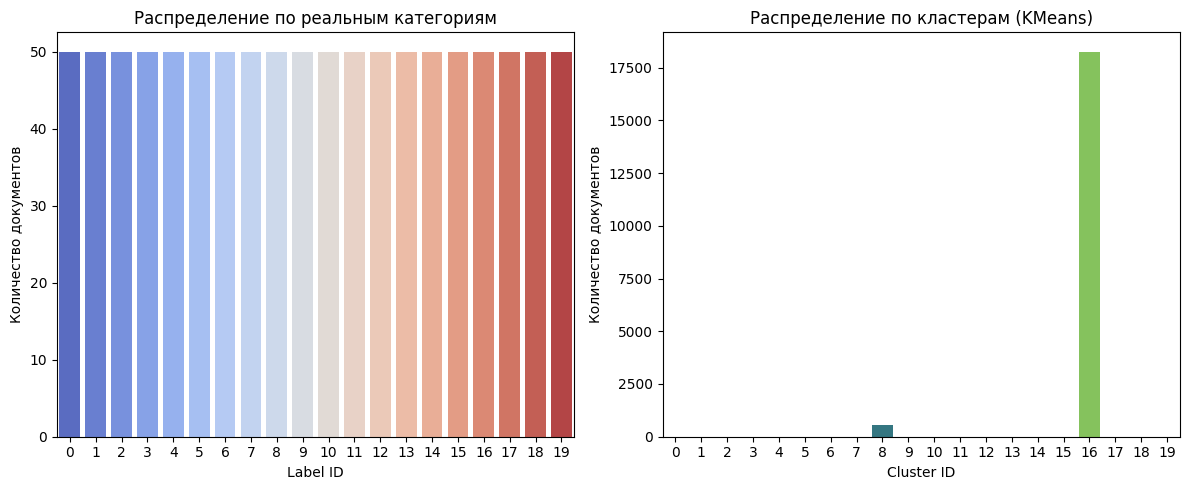

📊 Adjusted Rand Index (ARI): 0.0007 — насколько хорошо кластеры совпали с метками
📈 Silhouette Score: -0.0163 — насколько чёткие и отделимые получились кластеры


In [19]:
# Визуализация распределения по реальным категориям
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=labels, palette='coolwarm')
plt.title("Распределение по реальным категориям")
plt.xlabel("Label ID")
plt.ylabel("Количество документов")

# Визуализация распределения по кластерам
plt.subplot(1, 2, 2)
sns.countplot(x=clusters, palette='viridis')
plt.title("Распределение по кластерам (KMeans)")
plt.xlabel("Cluster ID")
plt.ylabel("Количество документов")

plt.tight_layout()
plt.show()

# 2. Метрики качества кластеризации
ari = adjusted_rand_score(labels1, clusters)
sil_score = silhouette_score(X1, clusters)

print(f"📊 Adjusted Rand Index (ARI): {ari:.4f} — насколько хорошо кластеры совпали с метками")
print(f"📈 Silhouette Score: {sil_score:.4f} — насколько чёткие и отделимые получились кластеры")

Ну, такое разделение неудивительно из-за огромного количества шума в данных и множества однотипных подкатегорий, потому разделение скорее всего бдует выглядеть не слишком реалистично



7. Разделение на train / val / test

In [20]:
#train+val / test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, labels, test_size=0.15, stratify=labels, random_state=42)

#train / val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=42)
# 0.1765 * 0.85 ≈ 0.15, чтобы val тоже была 15%

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")


Train size: 699
Validation size: 151
Test size: 150


# ЧАСТЬ 2

In [21]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
import evaluate
import numpy as np
import torch

Тут мы снова разделяем на выборки для лучшего обучения модели. Была взять тенировочная модель huggingface

In [22]:
idx_all = list(range(len(clean_texts)))

idx_trainval, idx_test = train_test_split(idx_all, test_size=0.15, stratify=labels, random_state=42)
idx_train, idx_val = train_test_split(idx_trainval, test_size=0.1765, stratify=[labels[i] for i in idx_trainval], random_state=42)

X_train_texts = [clean_texts[i] for i in idx_train]
y_train = [labels[i] for i in idx_train]

X_val_texts = [clean_texts[i] for i in idx_val]
y_val = [labels[i] for i in idx_val]

X_test_texts = [clean_texts[i] for i in idx_test]
y_test = [labels[i] for i in idx_test]

Подгружаем модельку